# Домашнее задание

#### Обучите CNN (самописная) на CIFAR-100.

#### Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

#### *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

Пойдем по порядку

1) Обучите CNN (самописная) на CIFAR-100.

In [1]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [2]:
dataset = datasets.CIFAR100(root='data/', train=True, download=True)


class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting data/cifar-100-python.tar.gz to data/


In [3]:
classes = dataset.classes
print(f'количество классов: {len(classes)}')
print(f'пример 5-ти классов из 100: {classes[95:]}')

количество классов: 100
пример 5-ти классов из 100: ['whale', 'willow_tree', 'wolf', 'woman', 'worm']


In [4]:
trans_actions = transforms.Compose([transforms.Resize(44),
                                    transforms.RandomCrop(32, padding=4), 
                                    transforms.ToTensor()])


def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [5]:
len(train_dataset), len(valid_dataset)

(47500, 2500)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True,
                          num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False,
                          num_workers=1)

torch.Size([128, 3, 32, 32])
forest


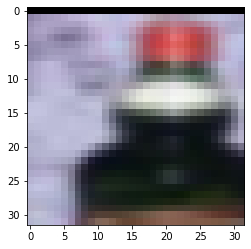

In [7]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[lbl[96]])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
torch.nn.Conv2d?

In [52]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 240)
        self.fc2 = torch.nn.Linear(240, 120)
        self.out = torch.nn.Linear(120, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=240, bias=True)
  (fc2): Linear(in_features=240, out_features=120, bias=True)
  (out): Linear(in_features=120, out_features=100, bias=True)
)


In [53]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [54]:
num_epochs = 10
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.036. Acc: 0.016. Test acc: 0.009
Epoch [1/10]. Step [301/372]. Loss: 0.034. Acc: 0.043. Test acc: 0.068
Epoch [2/10]. Step [1/372]. Loss: 0.030. Acc: 0.102. Test acc: 0.068
Epoch [2/10]. Step [301/372]. Loss: 0.031. Acc: 0.073. Test acc: 0.089
Epoch [3/10]. Step [1/372]. Loss: 0.031. Acc: 0.094. Test acc: 0.085
Epoch [3/10]. Step [301/372]. Loss: 0.031. Acc: 0.089. Test acc: 0.104
Epoch [4/10]. Step [1/372]. Loss: 0.030. Acc: 0.078. Test acc: 0.083
Epoch [4/10]. Step [301/372]. Loss: 0.030. Acc: 0.105. Test acc: 0.116
Epoch [5/10]. Step [1/372]. Loss: 0.031. Acc: 0.102. Test acc: 0.115
Epoch [5/10]. Step [301/372]. Loss: 0.029. Acc: 0.111. Test acc: 0.120
Epoch [6/10]. Step [1/372]. Loss: 0.029. Acc: 0.141. Test acc: 0.124
Epoch [6/10]. Step [301/372]. Loss: 0.029. Acc: 0.121. Test acc: 0.128
Epoch [7/10]. Step [1/372]. Loss: 0.029. Acc: 0.125. Test acc: 0.158
Epoch [7/10]. Step [301/372]. Loss: 0.029. Acc: 0.128. Test acc: 0.133
Epoch [8/10]. Step [

Сеть кое-как обучается. За 10 эпох на 100 классах добились accuracy на трейне = 14,9%, на валидации=16,2%

2) Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.

In [55]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [56]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [57]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [60]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [62]:
resnet50 = resnet50.to(device)

In [63]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [64]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [66]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [68]:
num_epochs = 10
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.038. Acc: 0.008. Test acc: 0.010
Epoch [1/10]. Step [301/372]. Loss: 0.020. Acc: 0.397. Test acc: 0.515
Epoch [2/10]. Step [1/372]. Loss: 0.014. Acc: 0.484. Test acc: 0.510
Epoch [2/10]. Step [301/372]. Loss: 0.014. Acc: 0.535. Test acc: 0.559
Epoch [3/10]. Step [1/372]. Loss: 0.010. Acc: 0.648. Test acc: 0.541
Epoch [3/10]. Step [301/372]. Loss: 0.012. Acc: 0.564. Test acc: 0.566
Epoch [4/10]. Step [1/372]. Loss: 0.010. Acc: 0.656. Test acc: 0.570
Epoch [4/10]. Step [301/372]. Loss: 0.012. Acc: 0.580. Test acc: 0.567
Epoch [5/10]. Step [1/372]. Loss: 0.011. Acc: 0.562. Test acc: 0.564
Epoch [5/10]. Step [301/372]. Loss: 0.011. Acc: 0.588. Test acc: 0.584
Epoch [6/10]. Step [1/372]. Loss: 0.011. Acc: 0.602. Test acc: 0.570
Epoch [6/10]. Step [301/372]. Loss: 0.011. Acc: 0.594. Test acc: 0.575
Epoch [7/10]. Step [1/372]. Loss: 0.010. Acc: 0.633. Test acc: 0.569
Epoch [7/10]. Step [301/372]. Loss: 0.011. Acc: 0.604. Test acc: 0.579
Epoch [8/10]. Step [

Предобученная модель показывает гораздо больший accuracy на 100 классах:

на трейне = 61,4% 

на валидации = 59,4%

3) *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

In [79]:
train_transformations = transforms.Compose([
    transforms.Resize(size=(224, 224), ),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

valid_transformations = transforms.Compose([
    transforms.Resize(size=(224, 224), ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])
])

In [80]:
train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_transformations)
valid_dataset = MyOwnCifar(valid_dataset, valid_transformations)

In [81]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False,
                                           num_workers=1)

In [82]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [84]:
num_epochs = 10
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 300 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/10]. Step [1/372]. Loss: 0.031. Acc: 0.203. Test acc: 0.454
Epoch [1/10]. Step [301/372]. Loss: 0.026. Acc: 0.247. Test acc: 0.482
Epoch [2/10]. Step [1/372]. Loss: 0.027. Acc: 0.258. Test acc: 0.474
Epoch [2/10]. Step [301/372]. Loss: 0.024. Acc: 0.283. Test acc: 0.493
Epoch [3/10]. Step [1/372]. Loss: 0.021. Acc: 0.352. Test acc: 0.492
Epoch [3/10]. Step [301/372]. Loss: 0.023. Acc: 0.293. Test acc: 0.500
Epoch [4/10]. Step [1/372]. Loss: 0.023. Acc: 0.305. Test acc: 0.474
Epoch [4/10]. Step [301/372]. Loss: 0.023. Acc: 0.304. Test acc: 0.504
Epoch [5/10]. Step [1/372]. Loss: 0.023. Acc: 0.328. Test acc: 0.476
Epoch [5/10]. Step [301/372]. Loss: 0.022. Acc: 0.308. Test acc: 0.503
Epoch [6/10]. Step [1/372]. Loss: 0.025. Acc: 0.305. Test acc: 0.492
Epoch [6/10]. Step [301/372]. Loss: 0.022. Acc: 0.312. Test acc: 0.501
Epoch [7/10]. Step [1/372]. Loss: 0.024. Acc: 0.266. Test acc: 0.486
Epoch [7/10]. Step [301/372]. Loss: 0.022. Acc: 0.319. Test acc: 0.493
Epoch [8/10]. Step [

Аугментация данных для обучения сработала немного странно. На трейне (там, где мы как раз крутили-вертели и кропали изображения) метрика достаточно низкая )accuracy = 32,6%)

На валидации accuracy = 32,6%